# Neoclassical transport and fast ions
- In this tutorial, we will show how to optimize for the effective ripple in DESC.
The computation involves integration over ripple wells whose structure determines the optimal resolution for the optimization.
So we will also breifly show how to visualize the ripples and accordingly pick resolution parameters.
The same tutorial can be used to optimize for fast ion confinement with Γ_c. To do so, replace the objective ``EffectiveRipple`` with ``GammaC``.

- Note that there is still work in progress to improve the performance in DESC by an order of magnitude. See the GitHub issues linked in the objective docstring if you would like to contribute.

## Neoclassical transport in banana regime
A 3D stellarator magnetic field admits ripple wells that lead to enhanced
radial drift of trapped particles. In the banana regime, neoclassical (thermal)
transport from ripple wells can become the dominant transport channel.
The effective ripple (ε) proxy estimates the neoclassical transport
coefficients in the banana regime. To ensure low neoclassical transport,
a stellarator is typically optimized so that ε < 0.02.

## Fast ion confinement
The energetic particle confinement
metric γ_c quantifies whether the contours of the second adiabatic invariant
close on the flux surfaces. In the limit where the poloidal drift velocity
dominates the radial drift velocity, the contours lie parallel to flux
surfaces. The optimization metric Γ_c averages γ_c² over the distribution
of trapped particles on each flux surface.
The radial electric field has a negligible effect, since fast particles
have high energy with collisionless orbits, so it is assumed to be zero.

## References
- [Evaluation of 1/ν neoclassical transport in stellarators.](https://doi.org/10.1063/1.873749)
V. V. Nemov, S. V. Kasilov, W. Kernbichler, M. F. Heyn.
Phys. Plasmas 1 December 1999; 6 (12): 4622–4632.
- [Poloidal motion of trapped particle orbits in real-space coordinates.](
https://doi.org/10.1063/1.2912456)
V. V. Nemov, S. V. Kasilov, W. Kernbichler, G. O. Leitold.
Phys. Plasmas 1 May 2008; 15 (5): 052501.

In [1]:
# If DESC is not installed as described in the installation documentation,
# then these lines may be needed to run this notebook.
#
# import sys
# import os

# sys.path.insert(0, os.path.abspath("."))
# sys.path.append(os.path.abspath("../../../"))

If you have access to a GPU, uncomment the following two lines before any DESC or JAX related imports. You should see about an order of magnitude speed improvement with only these two lines of code!

In [2]:
from desc import set_device

set_device("gpu")

As mentioned in [DESC Documentation on performance tips](https://desc-docs.readthedocs.io/en/latest/performance_tips.html), one can use compilation cache directory to reduce the compilation overhead time. Note: One needs to create `jax-caches` folder manually.

In [3]:
# import jax

# jax.config.update("jax_compilation_cache_dir", "../jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [4]:
import numpy as np
from matplotlib import pyplot as plt

from desc.integrals import Bounce2D
from desc.examples import get
from desc.grid import LinearGridFlux
from desc.optimize import Optimizer
from desc.objectives import (
    ForceBalance,
    FixPsi,
    FixBoundaryR,
    FixBoundaryZ,
    GenericObjective,
    FixPressure,
    FixIota,
    AspectRatio,
    EffectiveRipple,
    ObjectiveFunction,
)

## Documentation
Please read the full documentation of the methods to understand what the input parameters do. In Jupyter Lab, you can click on the code and press ``Shift+Tab`` to pull up the documentation. Breifly,

- The equilibrium resolution determines the spectral resolution of the FourierZernike series fit to the boundary.
- The grid determines the flux surfaces to compute on and the resolution of FFTs.
- The parameters ``X`` and ``Y`` determine the spectral resolution of the map between coordinates that parameterize the boundary and field line coordinates.
- The parameter ``Y_B`` determines the resolution for the bounce point finding algorithm. Feel free to reduce this until the plots of $\vert B\vert$ along field lines do not change. If $\vert B\vert$ is high frequency, then a larger value will be needed (usually much larger than ``Y``).

## Plotting ripple wells

- Here we plot $\vert B\vert$ along field lines to see the structure of the ripple wells. This is beneficial to choose the resolution for the optimization.
- Due to limitations in JAX, it is recommended to plot the field lines and pick a reasonable, yet preferably tight, upper bound on the number of ripple wells. From the plots, we see that ``num_well=W * num_transit`` with ``W=10`` is a reasonable upper bound. By making this extra effort, the optimization will be ``Y_B/W`` times more performant. If one were to select something much less than ``10``, as shown in the next example, then it should be clear from the plot that some ripple wells are ignored, which is not desirable.

In [ ]:
def plot_wells(
    eq,
    grid,
    theta,
    Y_B=None,
    num_transit=3,
    num_well=None,
    num_pitch=10,
):
    """Plotting tool to help user set tighter upper bound on ``num_well``.

    Parameters
    ----------
    eq : Equilibrium
        Equilibrium to compute on.
    grid : AbstractGridFlux
        Tensor-product grid in (ρ, θ, ζ) with uniformly spaced nodes
        (θ, ζ) ∈ [0, 2π) × [0, 2π/NFP).
        Number of poloidal and toroidal nodes preferably rounded down to powers of two.
        Determines the flux surfaces to compute on and resolution of FFTs.
    theta : jnp.ndarray
        Shape (num rho, X, Y).
        DESC coordinates θ from ``Bounce2D.compute_theta``.
        ``X`` and ``Y`` are preferably rounded down to powers of two.
    Y_B : int
        Desired resolution for algorithm to compute bounce points.
        Default is double ``Y``.
    num_transit : int
        Number of toroidal transits to follow field line.
        In an axisymmetric device, field line integration over a single poloidal
        transit is sufficient to capture a surface average. For a 3D
        configuration, more transits will approximate surface averages on an
        irrational magnetic surface better, with diminishing returns.
    num_well : int
        Maximum number of wells to detect for each pitch and field line.
        Giving ``None`` will detect all wells but due to current limitations in
        JAX this will have worse performance.
        Specifying a number that tightly upper bounds the number of wells will
        increase performance. In general, an upper bound on the number of wells
        per toroidal transit is ``Aι+B`` where ``A``, ``B`` are the poloidal and
        toroidal Fourier resolution of B, respectively, in straight-field line
        PEST coordinates, and ι is the rotational transform normalized by 2π.
        A tighter upper bound than ``num_well=(Aι+B)*num_transit`` is preferable.
        The ``check_points`` or ``plot`` methods in ``desc.integrals.Bounce2D``
        are useful to select a reasonable value.
    num_pitch: int
        Number of pitch angles.

    Returns
    -------
    plots
        Matplotlib (fig, ax) tuples for the 1D plot of each field line.

    """
    data = eq.compute(Bounce2D.required_names + ["min_tz |B|", "max_tz |B|"], grid=grid)
    bounce = Bounce2D(grid, data, theta, Y_B, num_transit=num_transit)
    pitch_inv, _ = Bounce2D.get_pitch_inv_quad(
        grid.compress(data["min_tz |B|"]),
        grid.compress(data["max_tz |B|"]),
        num_pitch,
    )
    points = bounce.points(pitch_inv, num_well)
    plots = bounce.check_points(points, pitch_inv)
    return plots

We will plot the ripple wells for `precise QH` from DESC examples folder on multiple flux surfaces.

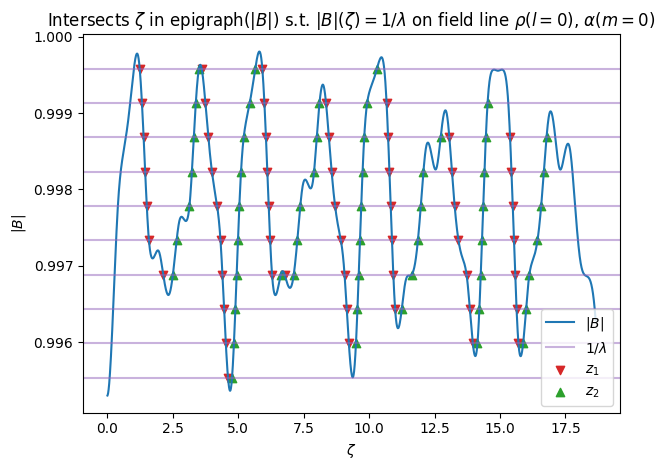

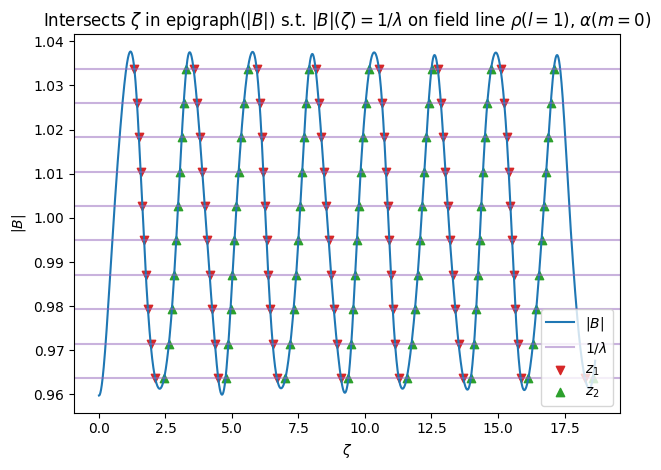

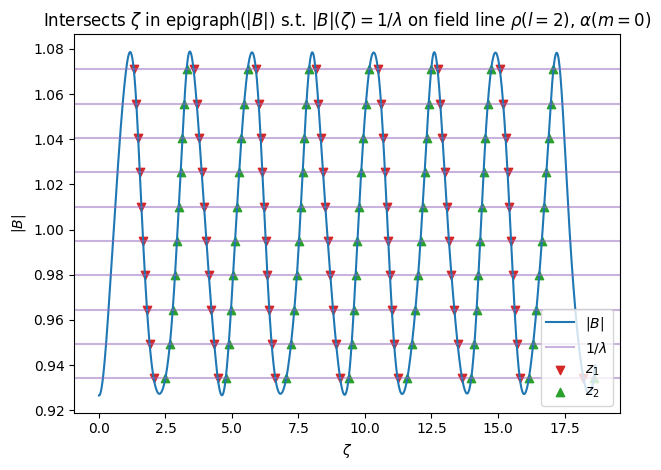

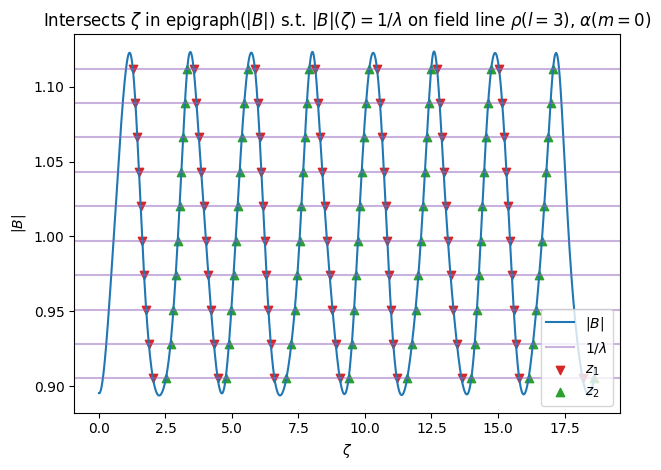

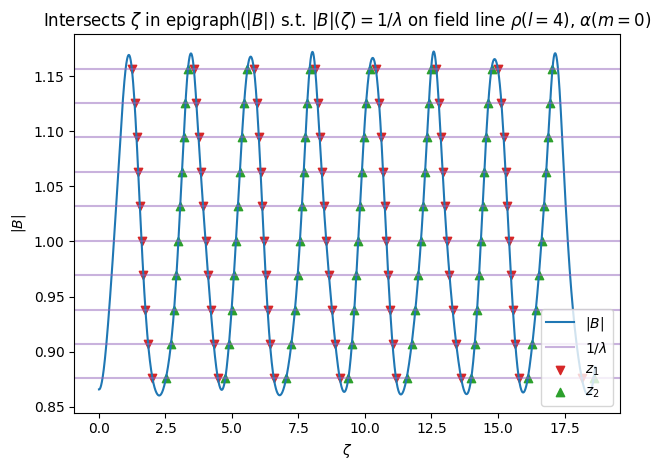

In [6]:
# ---------- Precise QH ----------
# Computing at higher resolution than necessary.
eq0 = get("precise_QH")
rho = np.linspace(0.01, 1, 5)
grid = LinearGridFlux(rho=rho, M=eq0.M_grid, N=eq0.N_grid, NFP=eq0.NFP, sym=False)

# ---------- How to pick resolution? ----------
# Plotting for 3 toroidal transits to see by eye
# Seems like these resolutions are more than sufficient.
# We will use more pitch angles for the integration.
X, Y = 16, 32
theta = Bounce2D.compute_theta(eq0, X, Y, rho)
num_transit = 3
Y_B = 32
plot_wells(
    eq0,
    grid,
    theta,
    Y_B,
    num_transit,
    num_well=10 * num_transit,
);

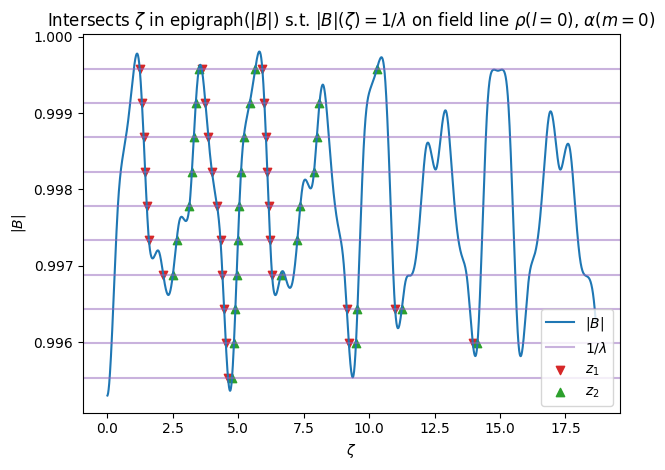

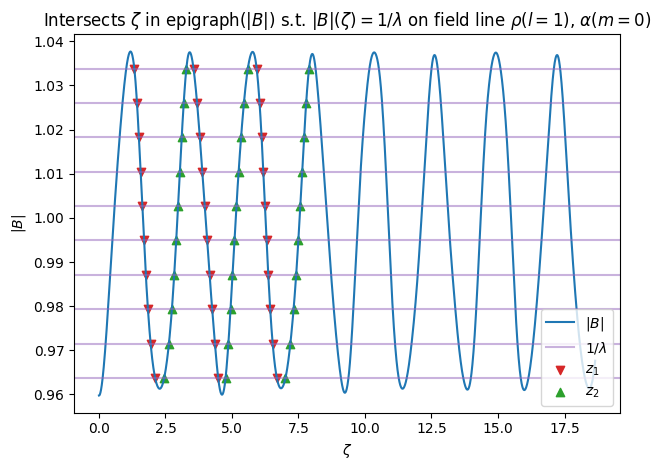

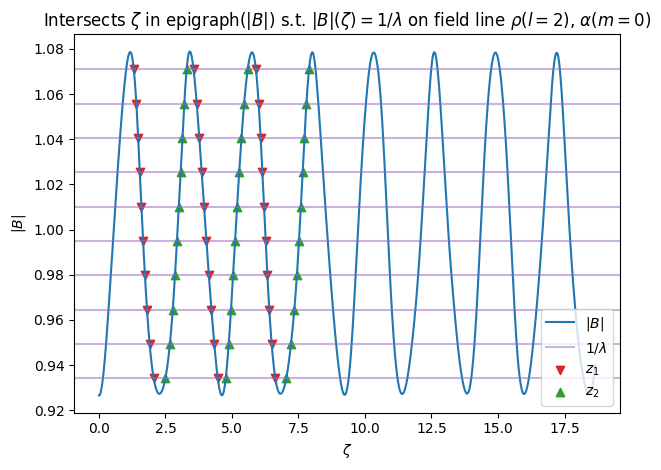

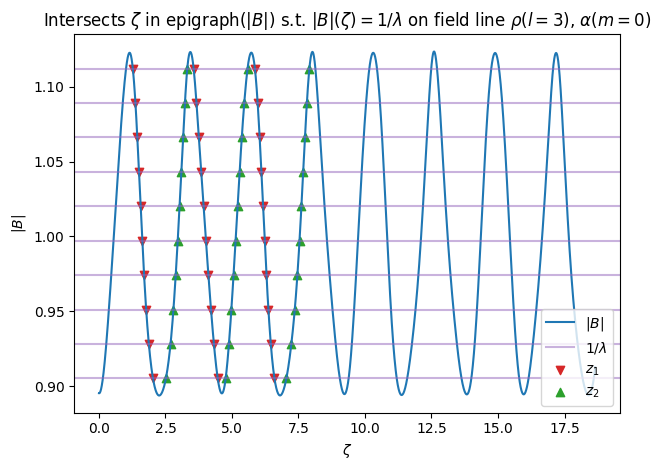

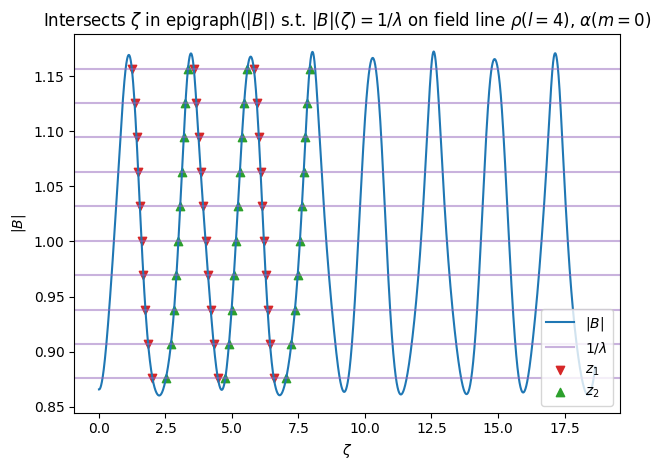

In [7]:
plot_wells(
    eq0,
    grid,
    theta,
    Y_B,
    num_transit,
    # Here we see some wells are ignored if num_well is too low.
    num_well=1 * num_transit,
);

## Calculating effective ripple for Precise QH

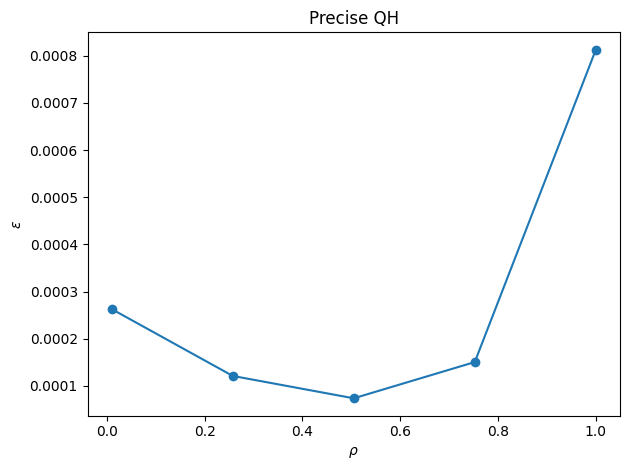

In [8]:
num_transit = 20
num_well = 10 * num_transit
num_quad = 32
num_pitch = 45
data = eq0.compute(
    "effective ripple",
    grid,
    theta=theta,
    Y_B=Y_B,
    num_transit=num_transit,
    num_well=num_well,
    num_quad=num_quad,
    num_pitch=num_pitch,
    # Can also specify ``pitch_batch_size`` which determines the
    # number of pitch values to compute simultaneously.
    # Reduce this if insufficient memory. If insufficient memory is detected
    # early then the code will exit and return ε = 0 everywhere. If not detected
    # early then typical OOM errors will occur.
)

eps = grid.compress(data["effective ripple"])
fig, ax = plt.subplots()
ax.plot(rho, eps, marker="o")
ax.set(xlabel=r"$\rho$", ylabel=r"$\epsilon$", title="Precise QH")
plt.tight_layout()
plt.show()

## Calculating effective ripple for Heliotron

Let us do a high resolution computation so that we are certain the optimization is successful when we compare to the optimized result later.

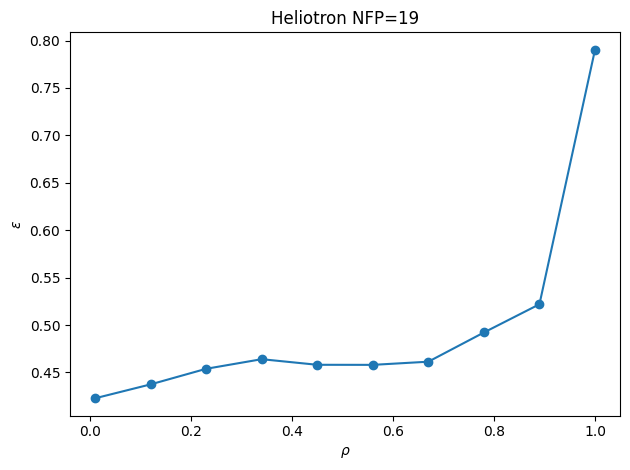

In [9]:
eq0 = get("HELIOTRON")
rho = np.linspace(0.01, 1, 10)
grid = LinearGridFlux(rho=rho, M=eq0.M_grid, N=eq0.N_grid, NFP=eq0.NFP, sym=False)
X = 32
Y = 64
Y_B = 133
num_transit = 20
num_well = 30 * num_transit
num_quad = 64
data = eq0.compute(
    "effective ripple",
    grid,
    theta=Bounce2D.compute_theta(eq0, X, Y, rho),
    Y_B=Y_B,
    num_transit=num_transit,
    num_well=num_well,
    num_quad=num_quad,
)

eps = grid.compress(data["effective ripple"])
fig, ax = plt.subplots()
ax.plot(rho, eps, marker="o")
ax.set(xlabel=r"$\rho$", ylabel=r"$\epsilon$", title="Heliotron NFP=19")
plt.tight_layout()
plt.show()

## Optimizing Heliotron

In [10]:
eq1 = eq0.copy()
k = 1
print()
print("---------------------------------------")
print(f"Optimizing boundary modes M, N <= {k}")
print("---------------------------------------")
modes_R = np.vstack(
    (
        [0, 0, 0],
        eq1.surface.R_basis.modes[np.max(np.abs(eq1.surface.R_basis.modes), 1) > k, :],
    )
)
modes_Z = eq1.surface.Z_basis.modes[np.max(np.abs(eq1.surface.Z_basis.modes), 1) > k, :]
constraints = (
    ForceBalance(eq=eq1),
    FixBoundaryR(eq=eq1, modes=modes_R),
    FixBoundaryZ(eq=eq1, modes=modes_Z),
    FixPressure(eq=eq1),
    FixIota(eq=eq1),
    FixPsi(eq=eq1),
)
curvature_grid = LinearGridFlux(
    rho=np.array([1.0]), M=eq1.M_grid, N=eq1.N_grid, NFP=eq1.NFP, sym=eq1.sym
)
ripple_grid = LinearGridFlux(
    rho=np.linspace(0.2, 1, 3), M=eq1.M_grid, N=eq1.N_grid, NFP=eq1.NFP, sym=False
)
objective = ObjectiveFunction(
    (
        EffectiveRipple(
            eq1,
            grid=ripple_grid,
            X=16,
            Y=32,
            Y_B=133,
            num_transit=10,
            num_well=25 * 10,
            num_quad=32,
            num_pitch=45,
            nufft_eps=1e-6,
        ),
        AspectRatio(eq1, bounds=(8, 11), weight=1e3),
        GenericObjective(
            "curvature_k2_rho", eq1, grid=curvature_grid, bounds=(-128, 10), weight=2e3
        ),
    )
)
optimizer = Optimizer("proximal-lsq-exact")
(eq1,), _ = optimizer.optimize(
    eq1,
    objective,
    constraints,
    ftol=1e-4,
    xtol=1e-6,
    gtol=1e-6,
    maxiter=5,
    verbose=3,
    options={"initial_trust_ratio": 2e-3},
)
print("Optimization complete!")


---------------------------------------
Optimizing boundary modes M, N <= 1
---------------------------------------
Building objective: Effective ripple
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 127 ms
Building objective: Generic
Timer: Objective build = 6.26 sec
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 2.50 sec
Timer: Objective build = 3.09 sec
Timer: Objective build = 2.99 ms
Timer: Eq Update LinearConstraintProjection build = 7.83 sec
Timer: Proximal projection build = 38.7 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed Psi
Timer: Objective build = 721 ms
Timer: LinearConstraintProjection build = 2.43 sec
Number of parameters: 8
Number of objectives: 251
Timer: Initializing the optimization = 42.0 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        C

In [11]:
data = eq1.compute(
    "effective ripple",
    grid,
    theta=Bounce2D.compute_theta(eq1, X, Y, rho),
    num_transit=num_transit,
    num_well=num_well,
    num_quad=num_quad,
)
eps_opt = grid.compress(data["effective ripple"])

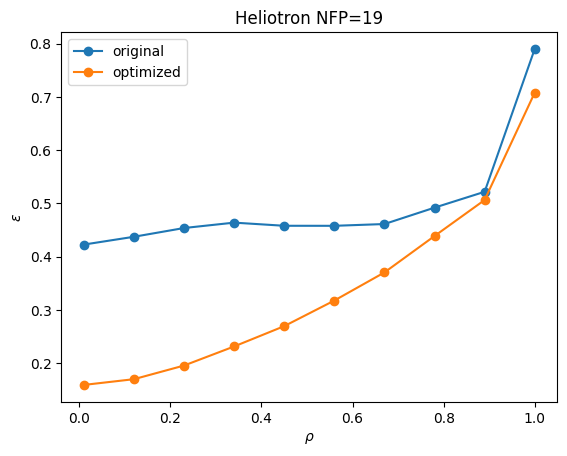

In [12]:
fig, ax = plt.subplots()
ax.plot(rho, eps, marker="o", label="original")
ax.plot(rho, eps_opt, marker="o", label="optimized")
ax.set(xlabel=r"$\rho$", ylabel=r"$\epsilon$", title="Heliotron NFP=19")
ax.legend();

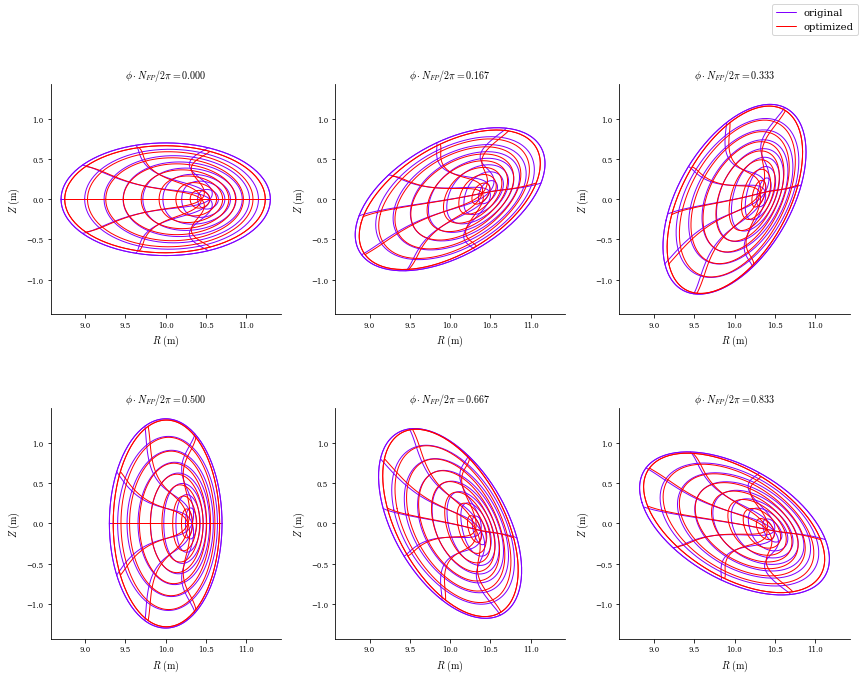

In [13]:
from desc.plotting import plot_comparison

plot_comparison(eqs=[eq0, eq1], labels=["original", "optimized"]);